# ***ML Prediction Model***
Here's what it does -
* Systematically combines all your factor scores into a single predictive model
*   Creates a model (Random Forest Regressor) to predict future composite scores based on calculated factor values.
* Enables forward-looking portfolio construction without recalculating composite scores.
*   Quantifies how well factors explain composite scores (R² metric).
* Identifies potential overfitting through cross-validation.





In [5]:
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


class FactorModelTrainer:

    def __init__(self, data_dir="/content", model_dir="models", factor_files=None, composite_file="composite_scores.csv"):
        self.data_dir = data_dir
        self.model_dir = model_dir
        self.factor_files = factor_files if factor_files is not None else {
            "value": "/content/value_scores.csv",
            "momentum": "/content/momentum_scores.csv",
            "quality": "/content/quality_scores.csv",
            "volatility": "/content/volatility_scores.csv",
            "volume": "/content/volume_scores.csv"
        }
        self.composite_file = composite_file
        self.df = None
        self.model = None
        self.best_model = None
        self.training_results = {}
        self.cv_results = {}
        self.tuning_results = {}
        self.evaluation_results = {}
        self.comparison_df = None # Initialize the attribute


    # Each score file has these columns - ['symbol', 'data', 'factor_score'].
    def _load_factors(self):
        dfs = []
        for factor, fname in self.factor_files.items():
            fpath = os.path.join(self.data_dir, fname)
            try:
                df = pd.read_csv(fpath)
                if df.shape[1] > 2:
                     df = df.rename(columns={df.columns[-1]: factor})
                else:
                     print(f"Warning: {fname} does not have expected score column structure.")
                     continue
                dfs.append(df)
            except FileNotFoundError:
                print(f"Error: Factor file not found at {fpath}")
                return None
            except Exception as e:
                print(f"An error occurred while reading {fpath}: {e}")
                return None
        return dfs

    def _merge_factors(self, factor_dfs):
        if not factor_dfs:
            return pd.DataFrame()
        merged = factor_dfs[0]
        for df in factor_dfs[1:]:
            merged = pd.merge(merged, df, on=["symbol", "date"], how="inner")
        return merged

    def _load_labels(self):
        fpath = os.path.join(self.data_dir, self.composite_file)
        try:
            return pd.read_csv(fpath)
        except FileNotFoundError:
            print(f"Error: Labels file not found at {fpath}")
            return None
        except Exception as e:
                print(f"An error occurred while reading {fpath}: {e}")
                return None

    def prepare_dataset(self):
        print("Preparing dataset...")
        factor_dfs = self._load_factors()
        if factor_dfs is None:
            self.df = pd.DataFrame()
            return self.df
        features = self._merge_factors(factor_dfs)

        labels = self._load_labels()
        if labels is None:
            self.df = pd.DataFrame()
            return self.df

        if features.empty or labels.empty:
            print("Warning: Features or labels DataFrame is empty after loading/merging.")
            self.df = pd.DataFrame()
            return self.df

        df = pd.merge(features, labels, on=["symbol", "date"], how="inner")
        df = df.dropna()
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)


        numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
        if 'composite_score' in numeric_cols:
            numeric_cols.remove('composite_score')

        large_value_threshold = 1e6
        decimal_places_to_keep = 2

        for col in numeric_cols:
            large_mask = df[col].abs() > large_value_threshold
            if large_mask.any():
                 df.loc[large_mask, col] = df.loc[large_mask, col].round(decimal_places_to_keep)
                 print(f"Reduced decimal places for large values in '{col}'.")


        self.df = df.copy()
        print("Dataset prepared.")
        return self.df

    def train_model(self):
        if self.df is None or self.df.empty:
            print("Error: No data available for training. Run prepare_dataset first.")
            return
        print("Training model...")

        X = self.df[["value", "momentum", "quality", "volatility", "volume"]]
        y = self.df["composite_score"]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        self.model = model

        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        self.training_results = {
            "RMSE": rmse,
            "R2 Score": r2
        }

        os.makedirs(self.model_dir, exist_ok=True)
        model_path = os.path.join(self.model_dir, "rf_model.pkl")
        joblib.dump(model, model_path)
        print(f"Model saved to {model_path}")

    def train_model_cv(self, cv=5):
        if self.df is None or self.df.empty:
            print("Error: No data available for cross-validation. Run prepare_dataset first.")
            return
        if self.model is None:
            print("Warning: Model not trained yet. Training a default model for CV.")
            model_for_cv = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        else:
             model_for_cv = self.model

        print(f"Performing {cv}-fold cross-validation...")
        X = self.df[["value", "momentum", "quality", "volatility", "volume"]]
        y = self.df["composite_score"]

        cv_scores = cross_val_score(model_for_cv, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
        cv_rmse_scores = np.sqrt(-cv_scores)

        mean_rmse = np.mean(cv_rmse_scores)
        std_rmse = np.std(cv_rmse_scores)

        self.cv_results = {
            "Mean RMSE": mean_rmse,
            "Std Dev RMSE": std_rmse
        }

    def evaluate_model(self):
        if self.df is None or self.df.empty:
            print("Error: No data available for evaluation. Run prepare_dataset first.")
            return
        if self.model is None:
            print("Error: Model not trained yet. Run train_model first.")
            return

        print("Evaluating model on test set...")
        X = self.df[["value", "momentum", "quality", "volatility", "volume"]]
        y = self.df["composite_score"]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        y_pred = self.model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        self.evaluation_results = {
            "RMSE": rmse,
            "R2 Score": r2
        }

        self.comparison_df = pd.DataFrame({'Actual': y_test.reset_index(drop=True), 'Predicted': y_pred})


        print("\nTest Set Evaluation:")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R2 Score: {r2:.4f}")


    def print_results(self):
        print("\nModel Training Results")
        if self.training_results:
            for metric, value in self.training_results.items():
                print(f"{metric}: {value:.4f}")

        print("\nCross-Validation Results")
        if self.cv_results:
            for metric, value in self.cv_results.items():
                print(f"{metric}: {value:.4f}")
        else:
            return

        print("\nTest Set Evaluation Results")
        if self.evaluation_results:
            for metric, value in self.evaluation_results.items():
                print(f"{metric}: {value:.4f}")
        else:
            return


In [6]:
trainer.train_model()
trainer.train_model_cv()
trainer.evaluate_model()
trainer.print_results()

Training model...
Model saved to models/rf_model.pkl
Performing 5-fold cross-validation...
Evaluating model on test set...

Test Set Evaluation:
  RMSE: 0.0003
  R2 Score: 1.0000

Model Training Results
RMSE: 0.0003
R2 Score: 1.0000

Cross-Validation Results
Mean RMSE: 0.0248
Std Dev RMSE: 0.0025

Test Set Evaluation Results
RMSE: 0.0003
R2 Score: 1.0000


Preparing dataset...
Dataset prepared.
Training model...
Model saved to models/rf_model.pkl
Evaluating model on test set...

Test Set Evaluation:
  RMSE: 0.0003
  R2 Score: 1.0000


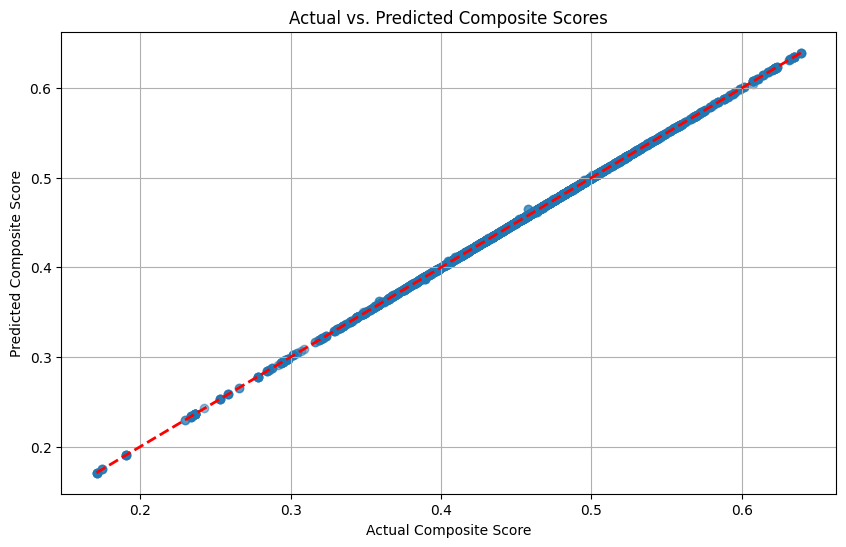

In [2]:
trainer = FactorModelTrainer(data_dir="/content")
trainer.prepare_dataset()
trainer.train_model()
trainer.evaluate_model()

plt.figure(figsize=(10, 6))
plt.scatter(trainer.comparison_df['Actual'], trainer.comparison_df['Predicted'], alpha=0.5)
min_val = min(trainer.comparison_df['Actual'].min(), trainer.comparison_df['Predicted'].min())
max_val = max(trainer.comparison_df['Actual'].max(), trainer.comparison_df['Predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Composite Score')
plt.ylabel('Predicted Composite Score')
plt.title('Actual vs. Predicted Composite Scores')
plt.grid(True)
plt.show()

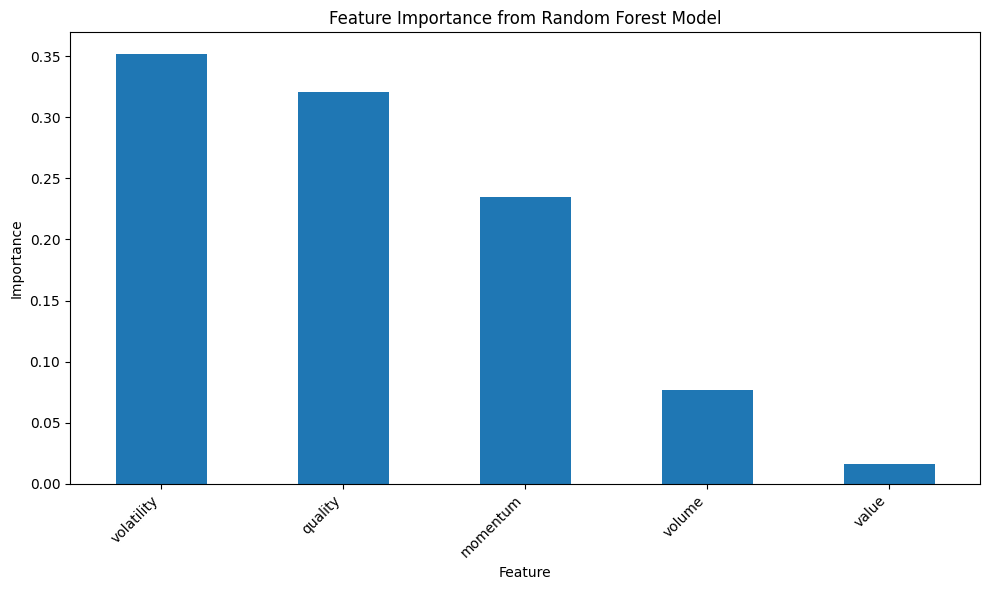

In [3]:
model = trainer.model
feature_names = ["value", "momentum", "quality", "volatility", "volume"]
feature_importances = model.feature_importances_
importance_series = pd.Series(feature_importances, index=feature_names)
sorted_importance = importance_series.sort_values(ascending=False)

# Bar plot
plt.figure(figsize=(10, 6))
sorted_importance.plot(kind='bar')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance from Random Forest Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()